In [1]:
import numpy as np
from dm_control import viewer
import matplotlib.pyplot as plt
from tqdm import tqdm
from simulation.dm_control.ddpg.ddpg import DDPGagent, OUNoise
import simulation.dm_control.simulation_control.environments as environments

In [2]:
random_state = np.random.RandomState(42)

PATH_MODEL = 'ddpg_actor.pt'
NUM_EPISODES = 2000
BATCH_SIZE = 128
DURATION = 100
ACTOR_LEARNING_RATE=1e-4
CRITIC_LEARNING_RATE=1e-3
GAMMA=0.99
TAU=1e-2

env = environments.load(domain_name='passive_hand', task_name='lift_sparse')
action_spec = env.action_spec()
dim_action = action_spec.shape[0]
dim_obs = 6

In [3]:
agent = DDPGagent(
    dim_obs,
    dim_action,
    actor_learning_rate=ACTOR_LEARNING_RATE,
    critic_learning_rate=CRITIC_LEARNING_RATE,
    gamma=GAMMA,
    tau=TAU
)
noise = OUNoise(dim_action, action_spec.minimum, action_spec.maximum)

def denorm(a): #  use on model output before passing to env
    act_k = (action_spec.maximum - action_spec.minimum) / 2.
    act_b = (action_spec.maximum + action_spec.minimum) / 2.
    return a * act_k + act_b

def norm(a): # use on env output before passing to model
    act_k_inv = 2. / (action_spec.maximum - action_spec.minimum)
    act_b = (action_spec.maximum + action_spec.minimum) / 2.
    return act_k_inv * (a - act_b)

def parse_obs(obs):
    """
    Take only gripper position and object position???
    """
    grip_pos = obs['grip_pos']
    object_pos = obs['object_pos']
    return np.append(grip_pos, object_pos)

def parse_act(act):
    # take translational actions only
    return act[:3]

def calc_reward(obs):
    """
    Calculate the reward based on stuffs
    observation=OrderedDict(
    [('grip_pos', array([1.38313716, 0.74702476, 0.58570326])),
    ('grip_velp', array([-1.02185151,  0.06579234, -0.62871064])),
    ('grip_velr', array([-0.01182298,  0.16122969, -0.00438519])),
    ('grip_rot', array([-0.00114049, -0.01091738,  0.00111363])),
    ('object_pos', array([1.45921682, 0.74832965, 0.41110006])),
    ('object_rel_pos', array([ 0.07607965,  0.00130489, -0.1746032 ])),
    ('object_velp', array([-0.10321769, -0.1453771 , -0.1968166 ])),
    ('object_velr', array([ 1.90336989, -0.97895901, -8.12644349])),
    ('object_rel_velp', array([ 0.91863382, -0.21116944,  0.43189404])),
    ('simulation_time', 0.12000000000000009)]))
    """
    grip_pos = obs['grip_pos']
    object_pos = obs['object_pos']
    obj_height = object_pos[2] - 0.41110006
    rel_dist = np.sum((object_pos - grip_pos) ** 2)**(1/2)
    return obj_height - rel_dist
    # return obj_height - rel_dist


100%|██████████| 2000/2000 [43:37<00:00,  1.31s/it]


episode: 0, reward: -54.53, average_reward: nan
episode: 1, reward: -61.2, average_reward: -54.526932033486794
episode: 2, reward: -25.66, average_reward: -57.862807978230094
episode: 3, reward: -46.11, average_reward: -47.1276530116717
episode: 4, reward: -25.09, average_reward: -46.87243072847116
episode: 5, reward: -28.46, average_reward: -42.51631786974391
episode: 6, reward: -23.19, average_reward: -40.17333057401973
episode: 7, reward: -26.51, average_reward: -37.7476995728252
episode: 8, reward: -26.93, average_reward: -36.34319875621092
episode: 9, reward: -30.55, average_reward: -35.297066276224776
episode: 10, reward: -23.44, average_reward: -34.822361488316865
episode: 11, reward: -24.37, average_reward: -31.71401725165096
episode: 12, reward: -39.04, average_reward: -28.03079183524894
episode: 13, reward: -34.93, average_reward: -29.368652447222168
episode: 14, reward: -30.57, average_reward: -28.251091151837546
episode: 15, reward: -26.73, average_reward: -28.7988498730941

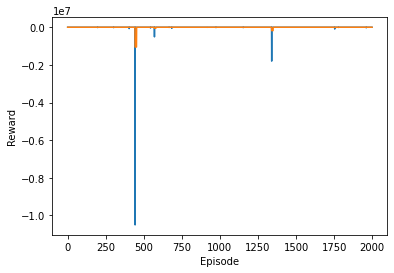

In [14]:
# rewards = []
# avg_rewards = []
#
# for episode in tqdm(range(NUM_EPISODES)):
#     time_step = env.reset()
#     state = parse_obs(time_step.observation)
#     noise.reset()
#     episode_reward = 0
#     for step in range(DURATION):
#         action = agent.get_action(state)
#         action = noise.get_action(action, step)
#         try:
#             time_step_2 = env.step(denorm(action))
#         except:
#             print(f'Physics Error: {action}')
#             break
#         state_2 = parse_obs(time_step_2.observation)
#         reward = calc_reward(time_step_2.observation)
#         agent.memory.push(state, action, reward, state_2, -1)
#         state = state_2
#         if len(agent.memory) > BATCH_SIZE:
#             agent.update(BATCH_SIZE)
#         episode_reward += reward
#     print(f"episode: {episode}, "
#       f"reward: {np.round(episode_reward, decimals=2)}, "
#       f"average_reward: {np.mean(rewards[-10:])}")
#     rewards.append(episode_reward)
#     avg_rewards.append(np.mean(rewards[-10:]))
#
# agent.save(PATH_MODEL)
#
# plt.plot(rewards)
# plt.plot(avg_rewards)
# plt.plot()
# plt.xlabel('Episode')
# plt.ylabel('Reward')
# plt.show()

In [5]:
agent.load(PATH_MODEL)
# Define a uniform random policy.
# ctr = 0
def policy(time_step):
    # global ctr
    state = parse_obs(time_step.observation)
    # print(calc_reward(time_step.observation))
    # print(denorm(agent.get_action(state)))
    # ctr += 1
    # if ctr == 100:
    #     raise Exception
    return denorm(agent.get_action(state))

def spec_policy(time_step):
    # print(calc_reward(time_step.observation))
    return np.array([-0.01,-0.01,-0.01,0.01,0.01])
# Launch the viewer application.
viewer.launch(env, policy=policy)
